<a href="https://colab.research.google.com/github/Tatiana130197/statistical-workshop/blob/main/task_fifth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание 5

Задание:

Качество классификации/регрессии методом k ближайших соседей зависит от нескольких параметров:
*   количество соседей n_neighbors
*   метрика расстояния между объектами
*   веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем меньше учитывается его "голос")

**1) Тренируйте классификатор KNeighborsClassifier на наборе данных.**

*   Предварительная обработка



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer


In [9]:
all_data = pd.read_csv("/content/drive/MyDrive/python/forest_dataset.csv")
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


In [10]:
all_data.shape

(10000, 55)

* Разделение на признаки и метки.

Извлекаем метки классов в переменную labels, а описания объектов - в переменную feature_matrix. Поскольку данные являются числовыми и не содержат пропущенных значений, мы преобразуем их в формат numpy, используя метод .values.

In [11]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

*  Разделим выборку на обучающие и тестовые наборы, используя метод train_test_split.

In [12]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

* Логистическая регрессия (из семинара):

In [13]:
clf = LogisticRegression(solver='saga')

# init GridSearchCV with parameters
param_grid = {
    'C': np.arange(1, 5),
    'penalty': ['l1', 'l2'],
}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

search.fit(feature_matrix, labels)

print(search.best_params_)

{'C': np.int64(2), 'penalty': 'l1'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
accuracy_score(labels, search.best_estimator_.predict(feature_matrix))

0.642

* Обучение модели kNN

In [15]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_feature_matrix, train_labels)

KNeighborsClassifier()

In [16]:
y_pred = clf.predict(test_feature_matrix)
accuracy_score(test_labels, y_pred)

0.7365

* Выберем параметры нашей модели:

 - Проведем итерацию по сетке от 1 до 10 для параметра number of neighbors
 - Используем другие метрики: манхэттенская, евклидова.
 - Используем разные стратегии расчета веса: равномерная, расстояние.

In [17]:
params = {
    'n_neighbors': np.arange(1, 10),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}

metrics_russian = {"euclidean": "Евклидова", "manhattan": "Манхэттенская"}
weights_russian = {"uniform": "Равномерная", "distance": "Расстояние"}

clf = KNeighborsClassifier()
clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(train_feature_matrix, train_labels)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Выведем наилучшие параметры:

In [18]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': np.int64(4), 'weights': 'distance'}

p. s. такой вывод мне нравится больше:

In [19]:
best_params = clf_grid.best_params_
print(f'Лучшие параметры: Число соседей = {best_params["n_neighbors"]}, Метрика = {metrics_russian[best_params["metric"]]}, Стратегия веса = {weights_russian[best_params["weights"]]}')

Лучшие параметры: Число соседей = 4, Метрика = Манхэттенская, Стратегия веса = Расстояние


In [20]:
accuracy_score(test_labels, clf_grid.best_estimator_.predict(test_feature_matrix))

0.7845

Используя найденное оптимальное количество соседей, вычислю вероятности принадлежности к классам для тестовой выборки (.`predict_proba`).

In [21]:
optimal_clf = clf_grid.best_estimator_
pred_prob = optimal_clf.predict_proba((test_feature_matrix))

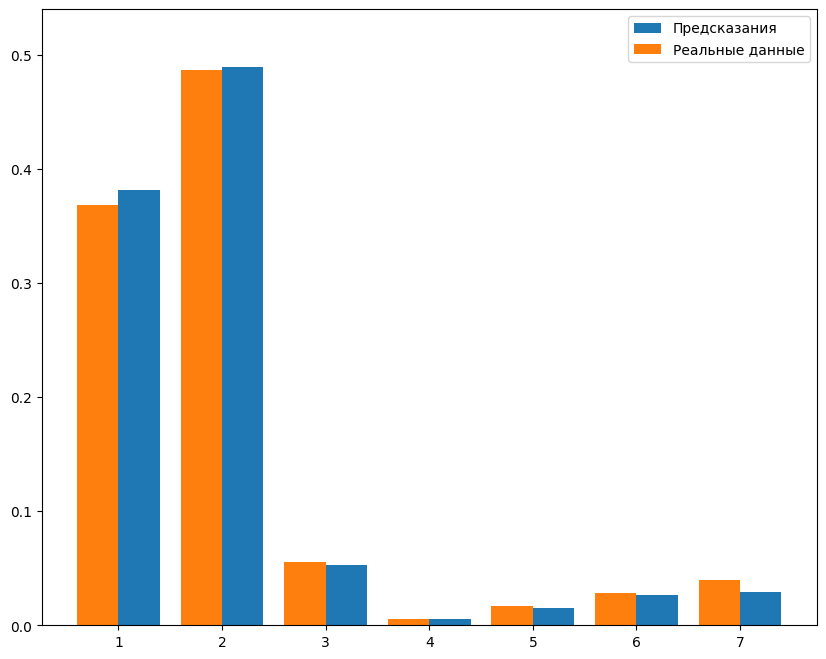

In [22]:
unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels), freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='Предсказания')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='Реальные данные')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

**Вывод.**

**2) Каково качество модели на тестовой выборке? Сравните ее с качеством логистической регрессии. Какая модель лучше? Почему? Каковы плюсы и минусы метода k ближайших соседей? Постройте ROC-кривую для метода k ближайших соседей. Рассчитайте площадь под кривой ROC (AUC-ROC).**

*Дублирую строчки кода, которые были ранее:*

1.   *Точность логистической регрессии*
2.   *Точность KNN*



In [23]:
accuracy_score(labels, search.best_estimator_.predict(feature_matrix))

0.642

In [24]:
accuracy_score(test_labels, clf_grid.best_estimator_.predict(test_feature_matrix))

0.7845

Поскольку KNN показывает более высокую точность, он лучше справляется с данной задачей. Это может быть связано с тем, что логистическая регрессия работает хуже на сложных, нелинейных зависимостях, а KNN способен лучше адаптироваться к таким данным.

Плюсы и минусы метода K ближайших соседей:

✅ Прост в реализации.

✅ Хорошо подходит для задач с нелинейными зависимостями.

✅ Не требует явного обучения — запоминает все примеры и принимает решение во время предсказания.

✅ Может быть эффективным при небольшом количестве данных.



---



❌ Медленный при больших объемах данных (из-за необходимости вычисления расстояний до всех точек).

❌ Чувствителен к шуму (выбросы могут сильно влиять на результат).

❌ Чувствителен к выбору k (неоптимальный выбор числа соседей ухудшает качество).

❌ Требует нормализации данных, так как чувствителен к масштабу признаков.

Количество классов:

In [25]:
np.unique(labels)

array([1, 2, 3, 4, 5, 6, 7])

Используем подход: One-vs-Rest *(или One-vs-All)*

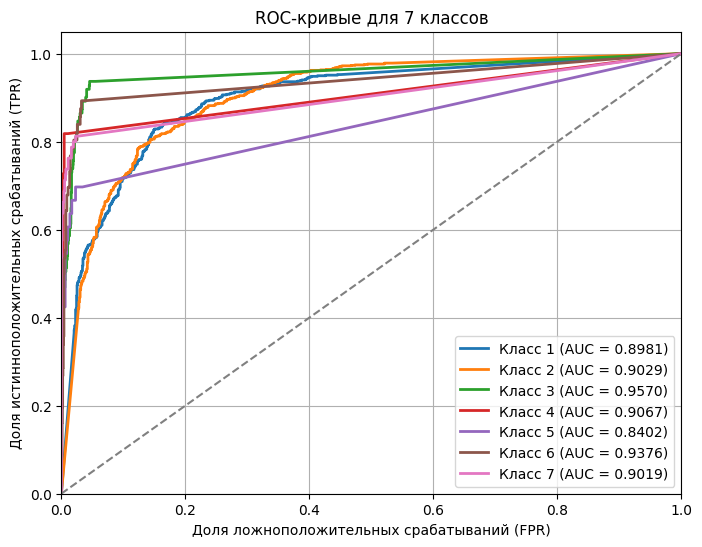

In [26]:
lb = LabelBinarizer()
y_bin = lb.fit_transform(test_labels)

y_scores = optimal_clf.predict_proba(test_feature_matrix)

plt.figure(figsize=(8, 6))

for i in range(len(lb.classes_)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Класс {lb.classes_[i]} (AUC = {roc_auc:.4f})')


plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных срабатываний (FPR)')
plt.ylabel('Доля истинноположительных срабатываний (TPR)')
plt.title('ROC-кривые для 7 классов')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Площадь под кривой ROC (AUC-ROC):

In [27]:
print(roc_auc)

0.9019466145833334


Модель правильно классифицирует объекты с вероятностью 90%, что довольно хорошо.